In [277]:
import torch
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from sklearn.cluster import KMeans

In [2]:
train = datasets.MNIST("", train=True, download=True, transform = transforms.Compose([transforms.ToTensor()]))

test = datasets.MNIST("", train=False, download=True, transform = transforms.Compose([transforms.ToTensor()]))


In [3]:
trainset = torch.utils.data.DataLoader(train, batch_size = 10, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size = 10, shuffle=True)

In [38]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 64, bias=0)
        self.fc2 = nn.Linear(64, 64, bias=0)
        self.fc3 = nn.Linear(64, 64, bias=0)
        self.fc4 = nn.Linear(64, 10, bias=0)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)
        

In [39]:
net = Net()
print(net)

Net(
  (fc1): Linear(in_features=784, out_features=64, bias=False)
  (fc2): Linear(in_features=64, out_features=64, bias=False)
  (fc3): Linear(in_features=64, out_features=64, bias=False)
  (fc4): Linear(in_features=64, out_features=10, bias=False)
)


In [40]:
X = torch.rand((28,28))
X = X.view(-1, 28*28)

In [7]:
output = net(X)

In [8]:
output

tensor([[-2.3902, -2.3830, -2.1775, -2.3042, -2.3702, -2.4102, -2.2464, -2.3373,
         -2.1978, -2.2416]], grad_fn=<LogSoftmaxBackward>)

In [41]:
optimizer = optim.Adam(net.parameters(), lr=1e-3)

EPOCHS = 3

for epoch in range(EPOCHS):
    for data in trainset:
        X, y = data
        net.zero_grad()
        output = net(X.view(-1,28*28))
        loss = F.nll_loss(output, y)
        loss.backward()
        optimizer.step()
    print(loss)

tensor(0.3690, grad_fn=<NllLossBackward>)
tensor(0.0151, grad_fn=<NllLossBackward>)
tensor(0.1442, grad_fn=<NllLossBackward>)


In [42]:
correct = 0
total = 0

with torch.no_grad():
    for data in trainset:
        X, y = data
        output = net(X.view(-1, 28*28))
        for idx, i in enumerate(output):
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1
            
print(correct/total)

0.97965


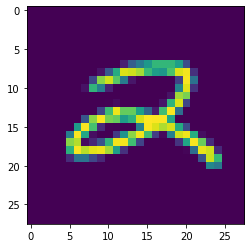

In [37]:
plt.imshow(X[2][0])

In [36]:
print(torch.argmax(net(X[2].view(-1,784))[0]))

tensor(2)


In [12]:
net.fc1, net.fc2, net.fc3, net.fc4

(Linear(in_features=784, out_features=64, bias=True),
 Linear(in_features=64, out_features=64, bias=True),
 Linear(in_features=64, out_features=64, bias=True),
 Linear(in_features=64, out_features=10, bias=True))

In [76]:
fc1_weights = list(net.fc1.parameters())

In [93]:
layer_weights = []
layer_weights.append(list(net.fc1.parameters())[0].detach().numpy())
layer_weights.append(list(net.fc2.parameters())[0].detach().numpy())
layer_weights.append(list(net.fc3.parameters())[0].detach().numpy())
layer_weights.append(list(net.fc4.parameters())[0].detach().numpy())


In [146]:
def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))

In [105]:
layer_weights[0].shape

(64, 784)

In [147]:
#B is determined by model architecture 
B = 4 
weight_blocks = []
for i in layer_weights[:-1]:
    weight_blocks.append(blockshaped(i, B, B))


In [150]:
all_blocks = np.concatenate((weight_blocks[0], weight_blocks[1], weight_blocks[2]))
all_blocks.shape
all_flat = []
for i in range(len(all_blocks)):
    all_flat.append(all_blocks[i].flatten())

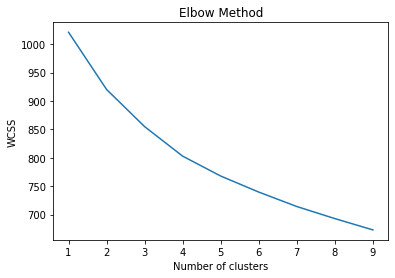

In [157]:
#N determined by architecture (how many legos can be fit)


N = 10
wcss = []
for i in range(1, N):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=500, n_init=10, random_state=0)
    kmeans.fit(all_flat)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, N), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [162]:
def distance(block, center):
    return np.linalg.norm(block - center)

In [276]:
#DELTA is determined by accuracy constraints 
#and architecture (how much is needed for back propagation)
DELTA = abs(.06343089 - 1.923427408)/3
centers = []
for i in kmeans.cluster_centers_:
    centers.append(np.reshape(i, (B,B)))

lego_set = []
k = 0
l = 0
for i in range(len(all_blocks)):
    for j in range(len(centers)):
        if distance(all_blocks[i], centers[j]) < DELTA:
            lego_set.append(centers[j])
            #if k % 50 == 0:
            #    print('lego used ', k)
            k += 1
        else:
            lego_set.append(all_blocks[i])
            #if l % 50 == 0:
            #    print('lego no used', l)
            l += 1
print(k/(k+l))

0.5719724658869396


In [170]:
# for reconstruction, save metadata about blocks location when creating it
# and use that in above code to modify the layers directly

0.01839387077762958


In [ ]:
#see if this is solving the memory overhead is an issue 